In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np

In [2]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [3]:
#запрос на 1000 строк, с полями "цена" и "тип комнаты" с возрастание по "id"
#посчитать 75перцентиль цены для типа "Private room"

q = '''
SELECT id,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]',  '')) as price,
        room_type 
    
FROM ldn_listings
ORDER BY id
LIMIT 1000

'''
df = ph.read_clickhouse(query=q, connection=connection_default)
df = df.query("room_type == 'Private room'")
df.price.quantile(0.75)

70.0

         room_type  price_mean  rating_mean
0  Entire home/apt  135.882950    93.568787
1       Hotel room  134.000000    92.500000
2     Private room   54.642437    94.766205
3      Shared room   21.000000    90.000000


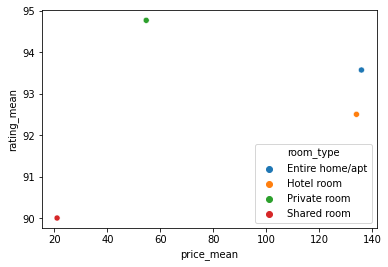

In [4]:
#в предыдущий запрос добавить поле с рейтингом (преобразовать в float)
# найти среднее цены и рейтинга в разбивке по room_type
q_2 = '''
SELECT room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]',  '')) as price,        
        toFloat32OrNull(review_scores_rating) as scores_rating
    
FROM ldn_listings
WHERE review_scores_rating != ''
ORDER BY id
LIMIT 1000


'''
df_2 = ph.read_clickhouse(query=q_2, connection=connection_default)
ddf_2 = df_2.groupby('room_type', as_index=False).agg({'price': 'mean'}).rename(columns={'price': 'price_mean'})
ddf_2['rating_mean'] = df_2.groupby('room_type', as_index=False).agg({'scores_rating': 'mean'}).scores_rating
print(ddf_2)
sns.scatterplot(data=ddf_2, x='price_mean', y='rating_mean', hue='room_type')

In [5]:
#запрос с уникальном host_id и host_verifications , experiences_offered не равном  'none'.


q_3 = '''
SELECT DISTINCT(host_id) as host_id,
        host_verifications 
    
FROM ldn_listings
WHERE experiences_offered != 'none'
GROUP BY host_id, host_verifications


'''
df_3 = ph.read_clickhouse(query=q_3, connection=connection_default)
df_3.head()

,host_id,host_verifications
0,6875353,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1,1146971,"['email', 'phone', 'manual_online', 'facebook'..."
2,10853976,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
3,2182162,"['email', 'phone', 'reviews', 'jumio', 'govern..."
4,19902892,"['email', 'phone', 'reviews', 'jumio']"


In [6]:
#раскрыть значения столбца host_verifications

chars = ['[', ']'] #символы для удаления из строк

#применяю lambda-функцию с удалением символов с сплитованием элементов по запятым
df_3['host_verifications'] = df_3.host_verifications \
                                 .apply(lambda x: x.translate(str.maketrans('', '', ''.join(chars))) \
                                 .split(','))
df_3.head()

,host_id,host_verifications
0,6875353,"['email', 'phone', 'reviews', 'jumio', 'go..."
1,1146971,"['email', 'phone', 'manual_online', 'facebo..."
2,10853976,"['email', 'phone', 'reviews', 'jumio', 'of..."
3,2182162,"['email', 'phone', 'reviews', 'jumio', 'go..."
4,19902892,"['email', 'phone', 'reviews', 'jumio']"


In [7]:
#метод expload для раскрытия списков из столбца "host_verifications" и считаем количество каждого из значений

hosts_by_verification_type = df_3.explode('host_verifications') \
                                .host_verifications \
                                .value_counts() \
                                .to_frame(name='count') \
                                .reset_index()
hosts_by_verification_type

,index,count
0,'phone',1345
1,'email',1345
2,'reviews',1309
3,'government_id',1196
4,'jumio',1115
5,'offline_government_id',469
6,'work_email',279
7,'facebook',270
8,'selfie',252
9,'identity_manual',227


 # Построить хитмэп количества "впечатлений" по району и типу впечатлений.

In [8]:
#запрос на кол-во впечатлений в группировке по району и типу впечатления

q_4 = '''
SELECT neighbourhood_cleansed,
        experiences_offered ,
        count(id) as experiences_count
        
FROM ldn_listings
GROUP BY neighbourhood_cleansed, 
        experiences_offered
ORDER BY experiences_count desc
LIMIT 100

'''
df_4 = ph.read_clickhouse(query=q_4, connection=connection_default)
df_4.head()

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Westminster,none,9599
1,Tower Hamlets,none,7973
2,Camden,none,6004
3,Hackney,none,5987
4,Kensington and Chelsea,none,5879


In [9]:
#сводная таблица

df_4_pivot = df_4.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')
df_4_pivot = df_4_pivot.drop(columns='none')
df_4_pivot.head()

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,NaN
Barnet,7.0,7.0,NaN,5.0
Bexley,NaN,NaN,NaN,NaN
Brent,9.0,21.0,NaN,6.0
Bromley,NaN,NaN,NaN,NaN


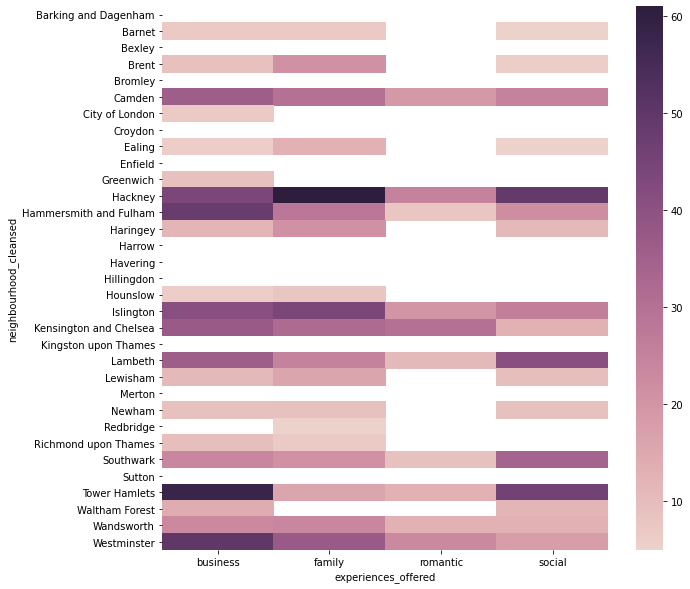

In [10]:
#построить хитмэп с палитрой

fig, ax = plt.subplots(figsize=(10,10)) 
cmap=sns.cubehelix_palette(as_cmap=True) #настройка палитры
sns.heatmap(df_4_pivot, cmap=cmap)

# Построить распределения цены (+log цены) по типу жилья

In [11]:
q_5 = '''
SELECT room_type,
    toFloat64OrNull(replaceRegexpAll(price, '[$,]', '')) as price
    
FROM ldn_listings
where experiences_offered  != 'none'

'''
df_5 = ph.read_clickhouse(query=q_5, connection=connection_default)
df_5.head()

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0


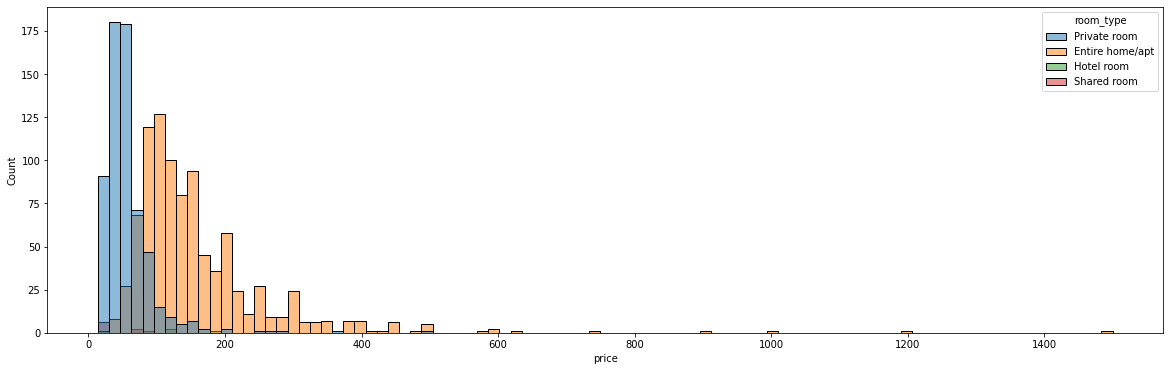

In [12]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.histplot(data = df_5, x='price', hue='room_type')

In [13]:
#логарифмированная цена
df_5_log = df_5
df_5_log['price'] = np.log(df_5_log['price'])
df_5_log.head()

,room_type,price
0,Private room,4.174387
1,Entire home/apt,4.605170
2,Private room,5.010635
3,Private room,3.806662
4,Private room,3.218876


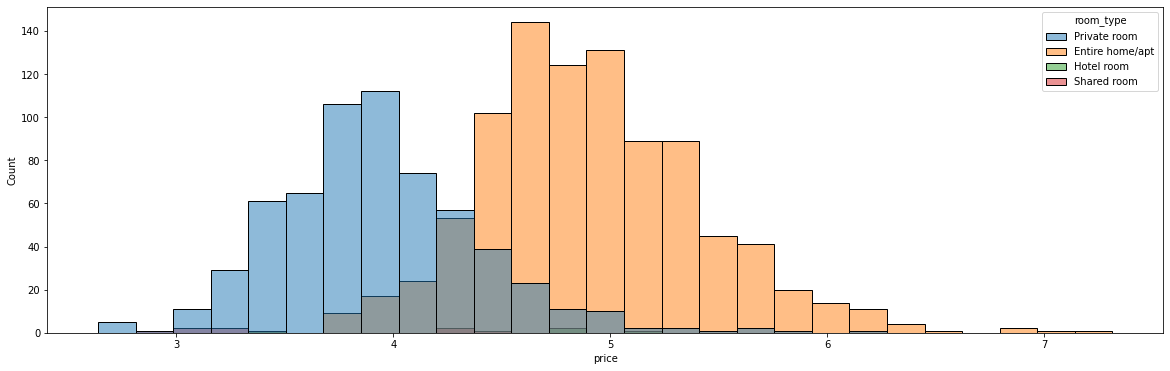

In [14]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.histplot(data = df_5_log, x='price', hue='room_type')

# Построить график динамики средних цен в зависимости от типа комнаты по годам

In [15]:
#запрос с фильтром на первый отзыв со 2го января 2010г.
q_6 = '''
SELECT room_type,
        toFloat64OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
        first_review
    
FROM ldn_listings
where toDateOrNull(first_review) > '2010-01-01'
limit 1000

'''
df_6 = ph.read_clickhouse(query=q_6, connection=connection_default)
df_6.head()

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16


In [25]:

df_6['first_review'] = df_6.first_review.apply(lambda x: x[:4]) #оставил год из даты
df_6 = df_6.groupby(['room_type', 'first_review'], as_index=False).agg({'price': 'mean'})
df_6.head()

,room_type,first_review,price
0,Entire home/apt,2010,103.500000
1,Entire home/apt,2011,128.792453
2,Entire home/apt,2012,135.467249
3,Entire home/apt,2013,137.887640
4,Entire home/apt,2014,154.583333


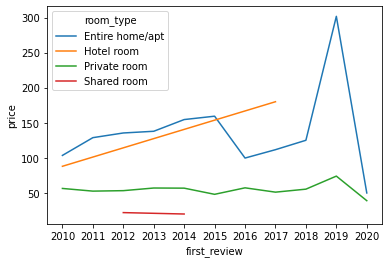

In [28]:
sns.lineplot(data=df_6, x='first_review', y='price', hue='room_type')